 # Proyecto Mineria TEL354
 #### Lucas Petit 202110025-3
 #### Martín Ortega 202030031-3

## Introducción
En este proyecto vamos vamos a analizar como el sueldo mínimo y otras variables afectan al desempleo recopilando y utilizando datos provenientes de las siguientes fuentes: el banco mundial, el banco central de chile y el instituto nacional de estadistica. Luego juntaremos esos datos para realizar graficos y regresiones comparandolos con la tasa de desempleo para ver su relación.

## Origen del problema
Durante la última comisión de hacienda se detallo el proyecto respecto a los siguientes cambios del sueldo minimo mensual, da lo cual se mostraron preocupaciones de parte de los legisladores que le hicieron notar al senador Garcia que “nos preocupan las implicancias como lo que está ocurriendo con la formalidad e informalidad laboral; que el reajuste no signifique mayor desempleo; sumado a que la economía del mundo está con turbulencias”.[1] 
Debido a esto queremos analizar como en la historia el cambio del sueldo minimo a afectado a la tasa de desempleo y agrupar el sueldo minimo con otras variable economicas para ver si hay una relación más clara.
> [1] https://www.senado.cl/comunicaciones/noticias/salario-minimo-hacen-presente-posibles-implicancias-en-desempleo-e

## Objetivo 
Nuestro objetivo es que nuestros analisis de los datos sean de utilidad para el ministerio del trabajo, el gobierno y congreso para que esten bien informados con respecto a las variables economicas que pueden afectar a la empleabilidad. Con los datos comprobaremos la relación historica del valor de los sueldos minimos con el desempleo.

## Agrupación y arreglo de datos en un solo dataframe

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

# Cargar los archivos CSV
sueldo_df = pd.read_csv("sueldo_minimo_chile.csv")           # 2009 a 2025
desempleo_df = pd.read_csv("Tasa desempleo.csv")               # 2010 a 2024 trimestres
empleo_df = pd.read_csv("tasa_empleo_formal_etario.csv")        # 2010 a 2024 trimestres
sueldo_nominal = pd.read_csv("sueldo_nominal_etario.csv")       # Anual 2010 a 2022
pib_percapita = pd.read_csv("Pib_percapita.csv")                # Anual 1960 a 2023
dolar = pd.read_csv("dolar.csv", sep=";")                       # Mensual 2007 a 2025
ipc = pd.read_csv("ipc.csv", encoding="latin", sep=";")         # Mensual 2010 a 2025 (2023=100)
tpm_df = pd.read_csv("tpm.csv")                                 # Mensual 2010 a 2022

# Renombrar la columna "Índice" a "ipc" en el DataFrame de IPC
ipc = ipc.rename(columns={"Índice": "ipc"})

# Definir listas y claves de merge (no se usan directamente, pero aquí se mantienen para referencia)
lista = ["Trimestre Móvil", "Tramo etario", "Value"]
merge_keys = ["Trimestre Móvil", "Tramo etario"]
display(desempleo_df)

,DTI_CL_INDICADOR,Indicador,DTI_CL_TRIMESTRE_MOVIL,Trimestre Móvil,DTI_CL_TRAMO_ETARIO,Tramo etario,Value,Flag Codes,Flags
0,ENE_TD_P2017,Tasa de desocupación (proyecciones base 2017),2020-V02,2020 ene-mar,_T,Total,8.228509,NaN,NaN
1,ENE_TD_P2017,Tasa de desocupación (proyecciones base 2017),2020-V02,2020 ene-mar,Y15T24,15-24 años,19.683771,NaN,NaN
2,ENE_TD_P2017,Tasa de desocupación (proyecciones base 2017),2020-V02,2020 ene-mar,Y25T34,25-34 años,10.017491,NaN,NaN
3,ENE_TD_P2017,Tasa de desocupación (proyecciones base 2017),2020-V02,2020 ene-mar,Y35T44,35-44 años,6.618948,NaN,NaN
4,ENE_TD_P2017,Tasa de desocupación (proyecciones base 2017),2020-V02,2020 ene-mar,Y45T54,45-54 años,5.598693,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1192,ENE_TD_P2017,Tasa de desocupación (proyecciones base 2017),2024-V04,2024 mar-may,Y25T34,25-34 años,9.321987,NaN,NaN
1193,ENE_TD_P2017,Tasa de desocupación (proyecciones base 2017),2024-V04,2024 mar-may,Y35T44,35-44 años,6.556797,NaN,NaN
1194,ENE_TD_P2017,Tasa de desocupación (proyecciones base 2017),2024-V04,2024 mar-may,Y45T54,45-54 años,7.376095,NaN,NaN
1195,ENE_TD_P2017,Tasa de desocupación (proyecciones base 2017),2024-V04,2024 mar-may,Y55T64,55-64 años,5.899829,NaN,NaN


Inicialmente trabajaremos con los dataframes en trimestres

In [22]:
# Fusionar los DataFrames de empleo formal y desempleo por "Trimestre Móvil" y "Tramo etario"
df_empleabilidad = pd.merge(
    empleo_df[["Trimestre Móvil", "Tramo etario", "Value"]],
    desempleo_df[["Trimestre Móvil", "Tramo etario", "Value"]],
    on=["Trimestre Móvil", "Tramo etario"],
    how="inner"
)

# Renombrar columnas para mayor claridad
df_empleabilidad = df_empleabilidad.rename(columns={
    "Value_x": "Tasa de empleo",
    "Value_y": "Tasa de desempleo"
})

# Extraer el año a partir de la columna "Trimestre Móvil"
df_empleabilidad["Año"] = df_empleabilidad["Trimestre Móvil"].str.extract(r"(\d{4})").astype(int)

# Diccionario para mapear abreviaturas de meses a números
meses = {
    "ene": 1, "feb": 2, "mar": 3, "abr": 4, "may": 5, "jun": 6,
    "jul": 7, "ago": 8, "sep": 9, "oct": 10, "nov": 11, "dic": 12
}

# Extraer el mes desde la columna "Trimestre Móvil" (se toma la parte de caracteres que representa el mes)
df_empleabilidad["Mes"] = df_empleabilidad["Trimestre Móvil"].str.slice(start=9, stop=12).replace(meses)

# Ajustar el año para los registros de enero, suponiendo que en ese caso corresponde al año siguiente
df_empleabilidad.loc[df_empleabilidad['Mes'] == 1, 'Año'] = df_empleabilidad[df_empleabilidad["Mes"] == 1]["Año"] + 1
df_empleabilidad

,Trimestre Móvil,Tramo etario,Tasa de empleo,Tasa de desempleo,Año,Mes
0,2010 ene-mar,Total,54.139000,9.227598,2010,3
1,2010 ene-mar,15-24 años,30.973043,20.215636,2010,3
2,2010 ene-mar,25-34 años,70.121048,10.727110,2010,3
3,2010 ene-mar,35-44 años,73.710138,6.867825,2010,3
4,2010 ene-mar,45-54 años,68.720825,6.300679,2010,3
...,...,...,...,...,...,...
1192,2024 mar-may,25-34 años,75.419463,9.321987,2024,5
1193,2024 mar-may,35-44 años,79.725150,6.556797,2024,5
1194,2024 mar-may,45-54 años,74.905781,7.376095,2024,5
1195,2024 mar-may,55-64 años,63.275477,5.899829,2024,5


Unimos los dataframe separados en trimestres y generamos la columnas Año y Mes para poder unir el dataframe con el resto
de datos.

In [24]:

display(sueldo_df.head(7))
display(dolar)
display(tpm_df)

,fecha,monto_clp
0,2009-07-01,165000
1,2010-07-01,172000
2,2011-07-01,182000
3,2012-07-01,193000
4,2013-07-01,210000
5,2014-07-01,225000
6,2015-07-01,241000


,Periodo,Dólar observado
0,ene.2007,"540,51"
1,feb.2007,"542,27"
2,mar.2007,"538,49"
3,abr.2007,"532,30"
4,may.2007,"522,02"
...,...,...
216,ene.2025,"1.000,76"
217,feb.2025,"956,62"
218,mar.2025,"932,55"
219,abr.2025,"961,96"


,Periodo,TPM
0,ene.2010,0.50
1,feb.2010,0.50
2,mar.2010,0.50
3,abr.2010,0.50
4,may.2010,0.50
...,...,...
151,ago.2022,9.75
152,sept.2022,10.55
153,oct.2022,11.07
154,nov.2022,11.25


dataframe sueldo mínimo originalmente solo estaba con entradas en las fechas que ocurrieron,
y dataframe de dolar observado y tpm con año y mes fusionados.

In [26]:
# Procesar el DataFrame de sueldo mínimo:

# Convertir la columna "fecha" a datetime, reindexar con un rango completo y rellenar valores faltantes
sueldo_df["fecha"] = pd.to_datetime(sueldo_df["fecha"], errors='coerce')
sueldo_df_c=sueldo_df.copy()
date_range = pd.date_range(start="2009-07-01", end="2025-05-01", freq='MS')
sueldo_df = sueldo_df.set_index("fecha").reindex(date_range).reset_index().ffill().rename(columns={"index": "fecha"})

# Extraer el año y el mes para realizar los merges
sueldo_df['Año'] = sueldo_df['fecha'].dt.year
sueldo_df['Mes'] = sueldo_df['fecha'].dt.month
sueldo_df = sueldo_df.rename(columns={"monto_clp": "Sueldo minimo"})

# Fusionar df_empleabilidad con sueldo_df por "Año" y "Mes"
df_empleabilidad = pd.merge(
    df_empleabilidad[["Año", "Mes", "Tramo etario", "Tasa de empleo", "Tasa de desempleo"]],
    sueldo_df[["Año", "Mes", "Sueldo minimo"]],
    on=["Año", "Mes"],
    how="inner"
)
# Fusionar con el DataFrame de IPC (ya renombrado a "ipc")
df_empleabilidad = pd.merge(
    df_empleabilidad,
    ipc[["Año", "Mes", "ipc"]],
    on=["Año", "Mes"],
    how="inner"
)
# Procesar el DataFrame del dólar
# Extraer el mes (de las primeras tres letras) y el año desde la columna "Periodo"
dolar["Mes"] = dolar["Periodo"].str.slice(start=0, stop=3).replace(meses)
dolar["Año"] = dolar["Periodo"].str.extract(r"(\d{4})").astype(int)

# Fusionar con el DataFrame de dólar
df_empleabilidad = pd.merge(
    df_empleabilidad,
    dolar[["Año", "Mes", "Dólar observado"]],
    on=["Año", "Mes"],
    how="inner"
)  # Hasta 2024

# Procesar el DataFrame del tpm
# Extraer el mes (de las primeras tres letras) y el año desde la columna "Periodo"
tpm_df["Mes"] = tpm_df["Periodo"].str.extract(r"^([a-zñ\.]+)").iloc[:, 0].str.replace(".", "", regex=False).map(meses)
tpm_df["Año"] = tpm_df["Periodo"].str.extract(r"(\d{4})").astype(int)

# Agregar la columna TPM a la copia del dataframe
df_empleabilidad = pd.merge(
    df_empleabilidad,
    tpm_df[["Año", "Mes", "TPM"]],
    on=["Año", "Mes"],
    how="inner"
)

display(sueldo_df)
display(df_empleabilidad)

,fecha,Sueldo minimo,Año,Mes
0,2009-07-01,165000.0,2009,7
1,2009-08-01,165000.0,2009,8
2,2009-09-01,165000.0,2009,9
3,2009-10-01,165000.0,2009,10
4,2009-11-01,165000.0,2009,11
...,...,...,...,...
186,2025-01-01,510636.0,2025,1
187,2025-02-01,510636.0,2025,2
188,2025-03-01,510636.0,2025,3
189,2025-04-01,510636.0,2025,4


,Año,Mes,Tramo etario,Tasa de empleo,Tasa de desempleo,Sueldo minimo,ipc,Dólar observado,TPM
0,2010,3,Total,54.139000,9.227598,165000.0,"57,82","523,16",0.50
1,2010,3,15-24 años,30.973043,20.215636,165000.0,"57,82","523,16",0.50
2,2010,3,25-34 años,70.121048,10.727110,165000.0,"57,82","523,16",0.50
3,2010,3,35-44 años,73.710138,6.867825,165000.0,"57,82","523,16",0.50
4,2010,3,45-54 años,68.720825,6.300679,165000.0,"57,82","523,16",0.50
...,...,...,...,...,...,...,...,...,...
982,2022,12,25-34 años,72.758222,8.969885,400000.0,"97,21","875,66",11.25
983,2022,12,35-44 años,77.752721,6.646202,400000.0,"97,21","875,66",11.25
984,2022,12,45-54 años,73.267255,6.337989,400000.0,"97,21","875,66",11.25
985,2022,12,55-64 años,60.654668,6.127412,400000.0,"97,21","875,66",11.25


Extendimos el dataframe de sueldo minimo para tener datos en todos los meses
y después fusionar con el resto, tambien unimos ipc que ya venia en año y mes.

In [28]:

display(pib_percapita)
display(pib_percapita[pib_percapita["Country Name"] == "Chile"])

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,Unnamed: 69
0,Aruba,ABW,PIB per cápita (US$ a precios actuales),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,27441.529662,28440.051964,30082.127645,31096.205074,22855.932320,27200.061079,30559.533535,33984.790620,NaN,NaN
1,NaN,AFE,PIB per cápita (US$ a precios actuales),NY.GDP.PCAP.CD,186.132432,186.947182,197.408105,225.447007,209.005786,226.883067,...,1329.777824,1520.171298,1538.924188,1493.780445,1344.080962,1522.590088,1628.024526,1659.515290,NaN,NaN
2,Afganistán,AFG,PIB per cápita (US$ a precios actuales),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,522.082216,525.469771,491.337221,496.602504,510.787063,356.496214,357.261153,415.707417,NaN,NaN
3,NaN,AFW,PIB per cápita (US$ a precios actuales),NY.GDP.PCAP.CD,121.938353,127.452629,133.825452,139.006714,148.547736,155.563837,...,1616.843198,1560.162999,1703.896392,1783.654365,1664.249176,1747.840549,1777.235012,1568.724310,NaN,NaN
4,Angola,AGO,PIB per cápita (US$ a precios actuales),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1807.952941,2437.259712,2538.591391,2189.855714,1449.922867,1925.874661,2929.694455,2308.159767,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,Kosovo,XKX,PIB per cápita (US$ a precios actuales),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,3759.449591,4009.317993,4384.186241,4415.997161,4310.888247,5270.426702,5290.947472,5960.158205,NaN,NaN
262,"Yemen, Rep. del",YEM,PIB per cápita (US$ a precios actuales),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,975.359407,811.165964,633.887206,623.376165,559.564673,522.173513,615.702079,477.409029,NaN,NaN
263,Sudáfrica,ZAF,PIB per cápita (US$ a precios actuales),NY.GDP.PCAP.CD,532.147504,545.657512,563.423009,604.536855,645.873376,684.621228,...,5651.205852,6618.335083,6914.178032,6533.711210,5580.603831,6843.399419,6523.410978,6022.542542,NaN,NaN
264,Zambia,ZMB,PIB per cápita (US$ a precios actuales),NY.GDP.PCAP.CD,221.559849,209.693206,202.281031,203.219451,229.979246,287.425476,...,1239.085279,1483.465773,1463.899979,1258.986198,951.644317,1127.160779,1447.123101,1330.727806,NaN,NaN


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,Unnamed: 69
39,Chile,CHL,PIB per cápita (US$ a precios actuales),NY.GDP.PCAP.CD,504.087277,580.102457,662.733476,644.89206,674.49014,677.767796,...,13649.852046,14879.908623,15659.480868,14495.716722,13114.815471,16216.570647,15451.131958,17067.813615,NaN,NaN


Dataframe PIB per capita con muchos paises, tenemos que tomar solo la parte de Chile.

In [30]:

# Procesar el DataFrame de PIB per cápita:
# Filtrar para Chile, eliminar columnas innecesarias, transponer y renombrar las columnas
pib_percapita = pib_percapita[pib_percapita["Country Name"] == "Chile"] \
    .drop(["Country Name", "Country Code", "Indicator Name", "Indicator Code"], axis=1) \
    .transpose().reset_index().rename(columns={"index": "Año", 39: "PIB per capita"}).dropna()
pib_percapita["Año"] = pib_percapita["Año"].astype(int)

# Fusionar con el DataFrame de empleabilidad usando el PIB per cápita (hasta 2023)
df_empleabilidad_pib = pd.merge(
    df_empleabilidad,
    pib_percapita,
    on=["Año"],
    how="inner"
)
display(df_empleabilidad_pib)

,Año,Mes,Tramo etario,Tasa de empleo,Tasa de desempleo,Sueldo minimo,ipc,Dólar observado,TPM,PIB per capita
0,2010,3,Total,54.139000,9.227598,165000.0,"57,82","523,16",0.50,12632.870473
1,2010,3,15-24 años,30.973043,20.215636,165000.0,"57,82","523,16",0.50,12632.870473
2,2010,3,25-34 años,70.121048,10.727110,165000.0,"57,82","523,16",0.50,12632.870473
3,2010,3,35-44 años,73.710138,6.867825,165000.0,"57,82","523,16",0.50,12632.870473
4,2010,3,45-54 años,68.720825,6.300679,165000.0,"57,82","523,16",0.50,12632.870473
...,...,...,...,...,...,...,...,...,...,...
982,2022,12,25-34 años,72.758222,8.969885,400000.0,"97,21","875,66",11.25,15451.131958
983,2022,12,35-44 años,77.752721,6.646202,400000.0,"97,21","875,66",11.25,15451.131958
984,2022,12,45-54 años,73.267255,6.337989,400000.0,"97,21","875,66",11.25,15451.131958
985,2022,12,55-64 años,60.654668,6.127412,400000.0,"97,21","875,66",11.25,15451.131958


Borramos las columnas que no necesitamos del dataframe de PIB per cabita, transponemos la fila y la fusionamos con el
resto de datos.

In [32]:
# Fusionar con el DataFrame de sueldo nominal (hasta 2022)
df_empleabilidad_sueldo = pd.merge(
    df_empleabilidad_pib,
    sueldo_nominal[["Año", "Tramo etario", "Value"]].rename(columns={"Value": "Sueldo nominal"}),
    on=["Año", "Tramo etario"],
    how="inner"
)

# Asegurarse que los valores de "ipc" sean numéricos; se reemplazan comas por puntos para convertirlos
df_empleabilidad_sueldo["ipc"] = pd.to_numeric(
    df_empleabilidad_sueldo["ipc"].astype(str).str.replace(",", "."),
    errors='coerce'
)

# Convertir "Dólar observado" a numérico, gestionando posibles comas
df_empleabilidad_sueldo["Dólar observado"] = pd.to_numeric(
    df_empleabilidad_sueldo["Dólar observado"].astype(str).str.replace(",", "."),
    errors='coerce'
)
df_empleabilidad_sueldo

,Año,Mes,Tramo etario,Tasa de empleo,Tasa de desempleo,Sueldo minimo,ipc,Dólar observado,TPM,PIB per capita,Sueldo nominal
0,2010,3,Total,54.139000,9.227598,165000.0,57.82,523.16,0.50,12632.870473,380807.9
1,2010,3,15-24 años,30.973043,20.215636,165000.0,57.82,523.16,0.50,12632.870473,199841.8
2,2010,3,25-34 años,70.121048,10.727110,165000.0,57.82,523.16,0.50,12632.870473,388164.0
3,2010,3,35-44 años,73.710138,6.867825,165000.0,57.82,523.16,0.50,12632.870473,430229.9
4,2010,3,45-54 años,68.720825,6.300679,165000.0,57.82,523.16,0.50,12632.870473,404290.3
...,...,...,...,...,...,...,...,...,...,...,...
982,2022,12,25-34 años,72.758222,8.969885,400000.0,97.21,875.66,11.25,15451.131958,740635.0
983,2022,12,35-44 años,77.752721,6.646202,400000.0,97.21,875.66,11.25,15451.131958,914302.2
984,2022,12,45-54 años,73.267255,6.337989,400000.0,97.21,875.66,11.25,15451.131958,812961.1
985,2022,12,55-64 años,60.654668,6.127412,400000.0,97.21,875.66,11.25,15451.131958,664046.1


Agregamos el dataframe de sueldo promedio y cambiamos las comas a puntos para volverlos valores númericos.

In [34]:
# Crear columna: Sueldo mínimo en USD dividiendo por el dólar observado y redondeando a 2 decimales
df_empleabilidad_sueldo["Sueldo mínimo USD"] = (
    df_empleabilidad_sueldo["Sueldo minimo"] / df_empleabilidad_sueldo["Dólar observado"]
).round(2)

# Crear columna: Sueldo nominal en USD redondeado igual que el anterior
df_empleabilidad_sueldo["Sueldo nominal USD"] = (
    df_empleabilidad_sueldo["Sueldo nominal"] / df_empleabilidad_sueldo["Dólar observado"]
).round(2)

# Crear columna: Razón entre sueldo nominal y sueldo mínimo (ambos en USD) redondeado a 2 decimales
df_empleabilidad_sueldo["Razón sueldo nominal/minimo"] = (
    df_empleabilidad_sueldo["Sueldo nominal USD"] / df_empleabilidad_sueldo["Sueldo mínimo USD"]
).round(2)

# Crear columna: Razón entre sueldo minimo e ipc redondeado a 2 decimales
df_empleabilidad_sueldo["Razón sueldo minimo/ipc"] = (
    df_empleabilidad_sueldo["Sueldo minimo"] / df_empleabilidad_sueldo["ipc"]
).round(2)

#creo fecha para graficar en el tiempo
df_empleabilidad_sueldo['Fecha'] = pd.to_datetime(df_empleabilidad_sueldo["Año"].astype(str) + "-" + df_empleabilidad_sueldo["Mes"].astype(str) + "-1")

#dataframe con sueldo minimo sin ajustar
df_minimo=df_empleabilidad_sueldo

# Crear columna Booleana para marcar el período pandémico
df_empleabilidad_sueldo["Pandemia"] = (
    ((df_empleabilidad_sueldo["Año"] > 2020) & (df_empleabilidad_sueldo["Año"] < 2022))
    | ((df_empleabilidad_sueldo["Año"] == 2020) & (df_empleabilidad_sueldo["Mes"] >= 3))
    | ((df_empleabilidad_sueldo["Año"] == 2022) & (df_empleabilidad_sueldo["Mes"] <= 12))
)
df_empleabilidad_sueldo

,Año,Mes,Tramo etario,Tasa de empleo,Tasa de desempleo,Sueldo minimo,ipc,Dólar observado,TPM,PIB per capita,Sueldo nominal,Sueldo mínimo USD,Sueldo nominal USD,Razón sueldo nominal/minimo,Razón sueldo minimo/ipc,Fecha,Pandemia
0,2010,3,Total,54.139000,9.227598,165000.0,57.82,523.16,0.50,12632.870473,380807.9,315.39,727.90,2.31,2853.68,2010-03-01,False
1,2010,3,15-24 años,30.973043,20.215636,165000.0,57.82,523.16,0.50,12632.870473,199841.8,315.39,381.99,1.21,2853.68,2010-03-01,False
2,2010,3,25-34 años,70.121048,10.727110,165000.0,57.82,523.16,0.50,12632.870473,388164.0,315.39,741.96,2.35,2853.68,2010-03-01,False
3,2010,3,35-44 años,73.710138,6.867825,165000.0,57.82,523.16,0.50,12632.870473,430229.9,315.39,822.37,2.61,2853.68,2010-03-01,False
4,2010,3,45-54 años,68.720825,6.300679,165000.0,57.82,523.16,0.50,12632.870473,404290.3,315.39,772.79,2.45,2853.68,2010-03-01,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
982,2022,12,25-34 años,72.758222,8.969885,400000.0,97.21,875.66,11.25,15451.131958,740635.0,456.80,845.80,1.85,4114.80,2022-12-01,True
983,2022,12,35-44 años,77.752721,6.646202,400000.0,97.21,875.66,11.25,15451.131958,914302.2,456.80,1044.13,2.29,4114.80,2022-12-01,True
984,2022,12,45-54 años,73.267255,6.337989,400000.0,97.21,875.66,11.25,15451.131958,812961.1,456.80,928.40,2.03,4114.80,2022-12-01,True
985,2022,12,55-64 años,60.654668,6.127412,400000.0,97.21,875.66,11.25,15451.131958,664046.1,456.80,758.34,1.66,4114.80,2022-12-01,True


Agregamos columnas de los sueldos en USD, razón entre el sueldo nominal y el minimo y entre el sueldo minimo e ipc, además de agregar una variable booleana para el periodo de pandemia.

In [36]:
# Eliminar las columnas originales de sueldos en CLP para evitar confusiones
df_empleabilidad_sueldo = df_empleabilidad_sueldo.drop(columns=["Sueldo minimo", "Sueldo nominal"])

# Realizar la codificación de la variable categórica "Tramo etario" usando get_dummies
df_encoded = pd.get_dummies(df_empleabilidad_sueldo, columns=["Tramo etario"])
# dataframe separado con edades
df_etario= df_encoded[df_encoded["Tramo etario_Total"] == False].drop(columns=["Tramo etario_Total"]);
df_etario.reset_index(drop=True, inplace=True)
# Mostrar las primeras filas del DataFrame final
df_encoded

,Año,Mes,Tasa de empleo,Tasa de desempleo,ipc,Dólar observado,TPM,PIB per capita,Sueldo mínimo USD,Sueldo nominal USD,...,Razón sueldo minimo/ipc,Fecha,Pandemia,Tramo etario_15-24 años,Tramo etario_25-34 años,Tramo etario_35-44 años,Tramo etario_45-54 años,Tramo etario_55-64 años,Tramo etario_65 años y más,Tramo etario_Total
0,2010,3,54.139000,9.227598,57.82,523.16,0.50,12632.870473,315.39,727.90,...,2853.68,2010-03-01,False,False,False,False,False,False,False,True
1,2010,3,30.973043,20.215636,57.82,523.16,0.50,12632.870473,315.39,381.99,...,2853.68,2010-03-01,False,True,False,False,False,False,False,False
2,2010,3,70.121048,10.727110,57.82,523.16,0.50,12632.870473,315.39,741.96,...,2853.68,2010-03-01,False,False,True,False,False,False,False,False
3,2010,3,73.710138,6.867825,57.82,523.16,0.50,12632.870473,315.39,822.37,...,2853.68,2010-03-01,False,False,False,True,False,False,False,False
4,2010,3,68.720825,6.300679,57.82,523.16,0.50,12632.870473,315.39,772.79,...,2853.68,2010-03-01,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
982,2022,12,72.758222,8.969885,97.21,875.66,11.25,15451.131958,456.80,845.80,...,4114.80,2022-12-01,True,False,True,False,False,False,False,False
983,2022,12,77.752721,6.646202,97.21,875.66,11.25,15451.131958,456.80,1044.13,...,4114.80,2022-12-01,True,False,False,True,False,False,False,False
984,2022,12,73.267255,6.337989,97.21,875.66,11.25,15451.131958,456.80,928.40,...,4114.80,2022-12-01,True,False,False,False,True,False,False,False
985,2022,12,60.654668,6.127412,97.21,875.66,11.25,15451.131958,456.80,758.34,...,4114.80,2022-12-01,True,False,False,False,False,True,False,False


dataframe final haciendo encoding en la variable tramo etario.

Esta implementación tiene como objetivo central integrar múltiples fuentes de datos
socioeconómicos de Chile —como tasas de empleo, desempleo, sueldos, IPC, dólar observado y PIB per cápita— para construir un DataFrame unificado y limpio que permita analizar la evolución del mercado laboral en función de variables económicas clave. Para ello, se realizó una cuidadosa limpieza, estandarización y fusión de distintos conjuntos de datos, ajustando formatos de fecha, nombres de columnas y tipos de datos. También se generaron variables nuevas, como los sueldos en dólares y la razón entre sueldo nominal y mínimo, para facilitar comparaciones y análisis internacionales. La codificación de la variable categórica “Tramo etario” mediante get_dummies permite aplicar modelos estadísticos o de aprendizaje automático que requieran variables numéricas. Además, se identificó el período pandémico mediante una columna booleana, lo que permitirá controlar o analizar el impacto de la pandemia sobre las variables laborales. Esta integración rigurosa permite disponer de un conjunto de datos robusto para análisis econométrico o visualizaciones significativas.

In [39]:
df_etario.describe()

,Año,Mes,Tasa de empleo,Tasa de desempleo,ipc,Dólar observado,TPM,PIB per capita,Sueldo mínimo USD,Sueldo nominal USD,Razón sueldo nominal/minimo,Razón sueldo minimo/ipc,Fecha
count,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846
mean,2016.085106,6.340426,55.649790,7.479731,71.828156,638.943546,3.458298,14602.687757,397.287305,807.478865,2.040520,3508.791348,2016-07-12 05:57:26.808510464
min,2010.000000,1.000000,14.695963,1.406802,57.820000,462.940000,0.500000,12632.870473,307.450000,362.000000,0.950000,2830.190000,2010-03-01 00:00:00
25%,2013.000000,3.000000,29.619571,3.836181,62.980000,519.250000,2.500000,13649.852046,367.730000,693.145000,1.700000,3111.400000,2013-05-01 00:00:00
50%,2016.000000,6.000000,66.110112,5.460404,72.070000,650.140000,3.130000,14529.676721,396.900000,843.680000,2.140000,3554.670000,2016-07-01 00:00:00
75%,2019.000000,10.000000,74.609176,9.018478,77.960000,713.700000,4.900000,15451.131958,425.020000,958.637500,2.430000,3892.910000,2019-10-01 00:00:00
max,2022.000000,12.000000,79.445798,29.852019,97.210000,955.890000,11.250000,16216.570647,473.140000,1211.250000,3.040000,4224.310000,2022-12-01 00:00:00
std,3.700931,3.498429,22.602726,5.294645,9.460156,123.446231,2.104279,1037.732399,35.873785,205.077841,0.516045,413.600726,NaN


La tabla mostrada corresponde a un resumen estadístico de las variables numéricas del DataFrame df_etario, que contiene 924 observaciones. Se incluyen estadísticas como media, desviación estándar, mínimo, percentiles y máximo para variables como "Tasa de empleo", "Tasa de desempleo", "ipc", "Dólar observado", "PIB per capita", y distintos indicadores salariales.   
- La "Tasa de desempleo" tiene un promedio de 7.49% y un máximo de casi 30%, lo que refleja una alta variabilidad.
- El "Dólar observado" muestra una media de 639.6 y una desviación importante, con valores que van desde 462.94 hasta 955.89, evidenciando alta volatilidad.
- TPM varia desde 0.5% hasta 11.25%.
- El "PIB per capita" también presenta cierta variabilidad con un promedio cercano a los 14,600 USD.
- El "Sueldo mínimo USD" varía entre 307.45 y 473.14
- El "Sueldo nominal USD" va de 362 a más de 1,200 USD.
- La "Razón sueldo nominal/mínimo" tiene un valor medio de 2.04, lo que implica que en promedio el sueldo nominal duplica el mínimo, pero con casos donde la relación es apenas cercana a 1 y otros que superan el triple.
  
Estos indicadores proveen una base sólida para análisis exploratorios y modelos predictivos. Además, permiten estudiar la evolución del mercado laboral y su relación con condiciones económicas clave entre 2010 y 2022.

## Analizar la correlación del desempleo con las distintas variables

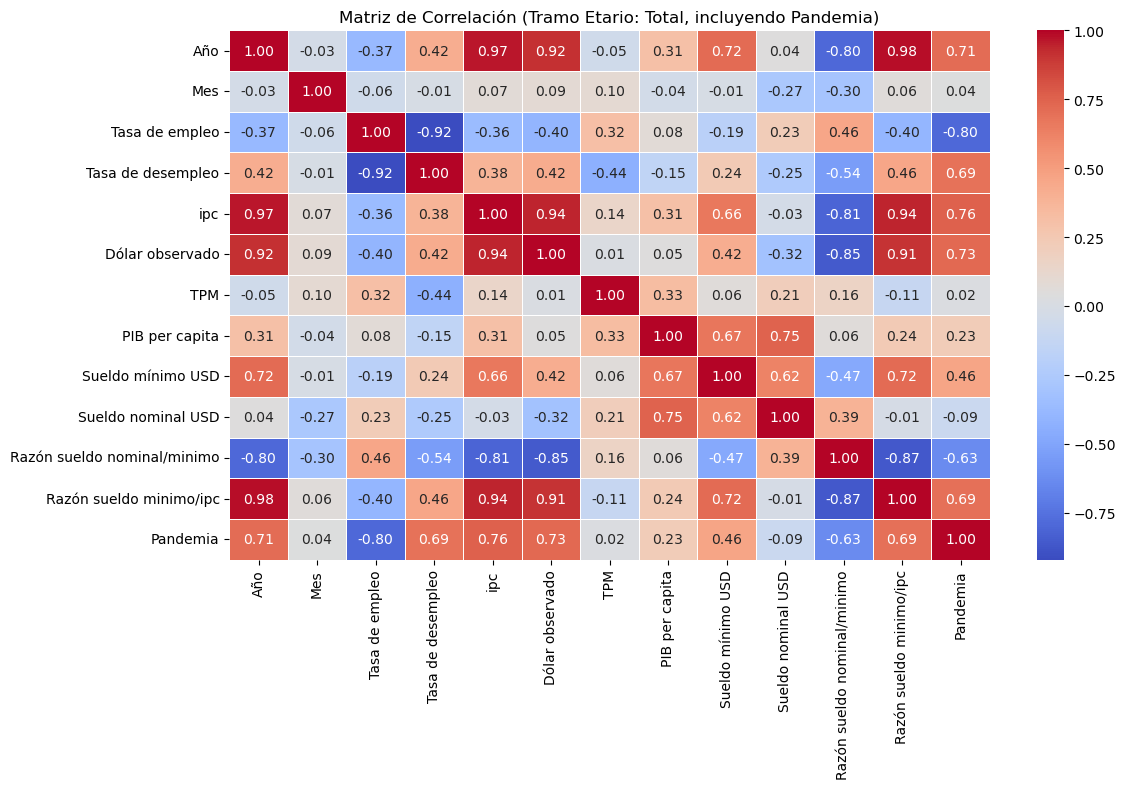


Suma de correlaciones absolutas (orden ascendente):
Mes                            2.062388
TPM                            2.953108
PIB per capita                 4.202263
Sueldo nominal USD             4.218266
Tasa de empleo                 5.582304
Tasa de desempleo              5.925479
Sueldo mínimo USD              6.249638
Pandemia                       6.852675
Dólar observado                7.069077
Año                            7.320253
Razón sueldo nominal/minimo    7.353287
ipc                            7.378642
Razón sueldo minimo/ipc        7.399086
dtype: float64

Mayores correlaciones absolutas con la tasa de desempleo:
Tasa de desempleo              1.000000
Tasa de empleo                 0.920316
Pandemia                       0.691733
Razón sueldo nominal/minimo    0.540976
Razón sueldo minimo/ipc        0.456634
TPM                            0.436811
Dólar observado                0.424350
Año                            0.420517
ipc                            0.

In [42]:
# Filtrar solo las filas donde el tramo etario sea "Total"
df_total = df_encoded[df_encoded["Tramo etario_Total"] == 1].copy()

# Asegurar que la columna Pandemia esté presente y sea numérica (True -> 1, False -> 0)
if "Pandemia" in df_total.columns:
    df_total["Pandemia"] = df_total["Pandemia"].astype(int)

# Seleccionar solo columnas numéricas
df_total_numeric = df_total.select_dtypes(include="number")

# Calcular la matriz de correlación
correlation_matrix = df_total_numeric.corr()

# Visualizar con un mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Matriz de Correlación (Tramo Etario: Total, incluyendo Pandemia)")
plt.savefig('a.png', dpi=1000) 
plt.tight_layout()
plt.show()

# Calcular y mostrar suma de correlaciones absolutas (orden ascendente)
suma_corr_abs = correlation_matrix.abs().sum().sort_values()
print("\nSuma de correlaciones absolutas (orden ascendente):")
print(suma_corr_abs)
print("\nMayores correlaciones absolutas con la tasa de desempleo:")
print(correlation_matrix["Tasa de desempleo"].abs().sort_values(ascending=False))

Esta sección del código tiene como propósito analizar las relaciones entre las variables numéricas del conjunto de datos filtrado, específicamente para el tramo etario “Total”. Para lograrlo, primero se seleccionan únicamente las filas donde la columna Tramo etario_Total tenga valor 1, es decir, aquellas que representan el promedio general sin segmentación por edad. Esta decisión permite simplificar el análisis y enfocarse en el comportamiento agregado de las variables laborales y económicas a lo largo del tiempo, sin la variabilidad introducida por las diferencias etarias.

La tasa de desempleo muestra una correlación moderadamente positiva con variables como el año (0.42), el IPC (0.38), la razón sueldo mínimo/ipc (0.46) y el dólar observado (0.43), lo que indica que tiende a aumentar con el paso del tiempo, la inflación y la devaluación del peso. La pandemia presenta una fuerte correlación positiva (0.69), reflejando su impacto negativo en el empleo. En contraste, presenta una correlación moderadamente negativa con la razón sueldo nominal/mínimo (-0.55) y débilmente negativa con el sueldo nominal USD (-0.26), sugiriendo que mayores ingresos reales están asociados a menores niveles de desempleo. El PIB per cápita tiene una relación débilmente negativa (-0.17), mientras que el sueldo mínimo en USD tiene una débil relación positiva (0.24), posiblemente reflejando efectos mixtos en el mercado laboral. La variable mes muestra una correlación nula, lo que indica ausencia de estacionalidad marcada. En conjunto, el desempleo se ve más influido por condiciones macroeconómicas e impactos extraordinarios que por variaciones de corto plazo.

## Graficos de dispersion con variables relacionadas con el desempleo.

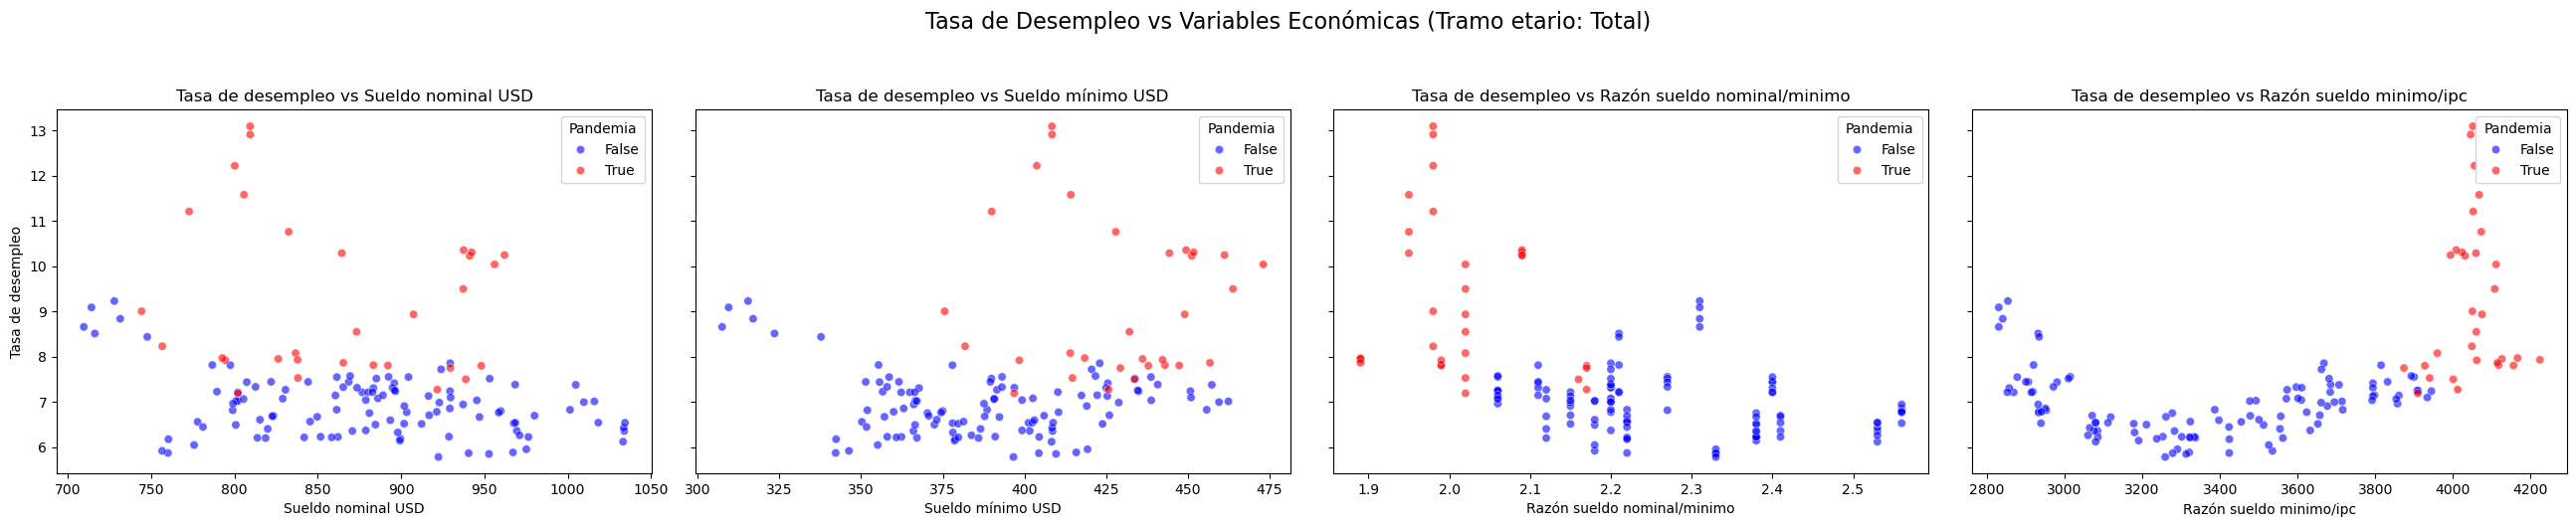

In [46]:
# Filtrar solo las filas donde el tramo etario sea "Total"
df_total = df_encoded[df_encoded["Tramo etario_Total"] == 1].copy()

# Asegurarse que la columna Pandemia esté en formato booleano
df_total["Pandemia"] = df_total["Pandemia"].astype(bool)

# Columnas de interés para este gráfico (agregamos la nueva variable)
x_vars = [
    "Sueldo nominal USD",
    "Sueldo mínimo USD",
    "Razón sueldo nominal/minimo",
    "Razón sueldo minimo/ipc"
]
x_vars_2 = [
    "PIB per capita",
    "Dólar observado",
    "ipc",
    "TPM"
]
y_var = "Tasa de desempleo"

# Eliminar filas con valores faltantes
df_plot = df_total[[y_var, "Pandemia"] + x_vars].dropna()

# Crear una fila de subplots
fig, axes = plt.subplots(1, len(x_vars), figsize=(26, 5), sharey=True)
# Generar scatterplots para cada variable explicativa
for i, var in enumerate(x_vars):
    sns.scatterplot(
        data=df_plot,
        x=var,
        y=y_var,
        hue="Pandemia",
        ax=axes[i],
        alpha=0.6,
        palette={True: "red", False: "blue"}
    )
    axes[i].set_title(f"{y_var} vs {var}")
    axes[i].legend().set_title("Pandemia")

# Ajustar presentación
plt.suptitle("Tasa de Desempleo vs Variables Económicas (Tramo etario: Total)", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()



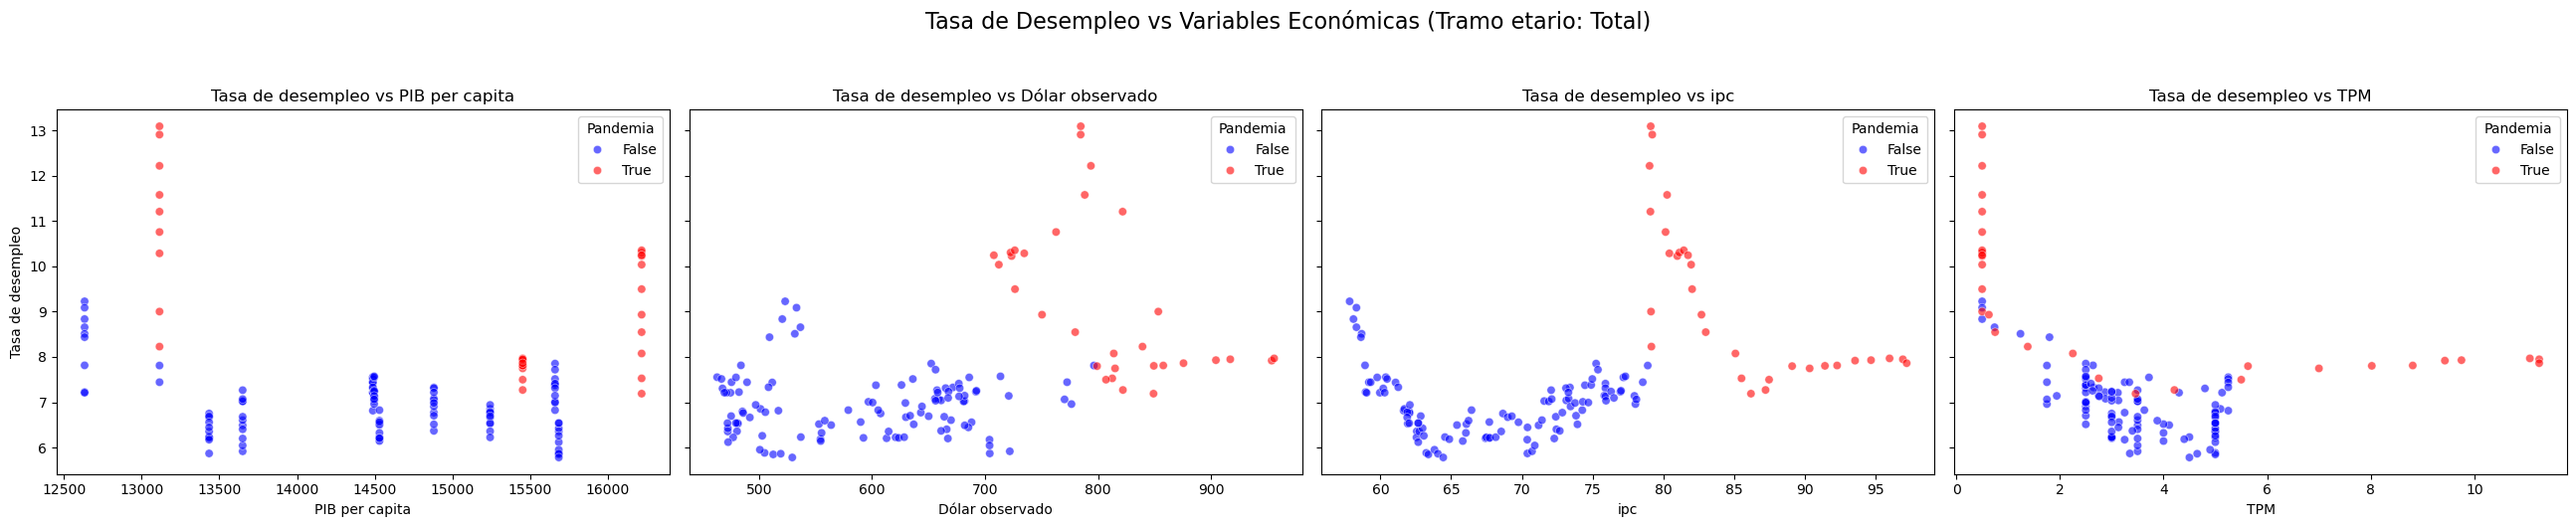

In [47]:
# Eliminar filas con valores faltantes
df_plot = df_total[[y_var, "Pandemia"] + x_vars_2].dropna()
# Crear una fila de subplots
fig, axes = plt.subplots(1, len(x_vars_2), figsize=(26, 5), sharey=True)
#fig, axes = plt.subplots(1, 4, figsize=(26, 4), sharey=True)
# Generar scatterplots para cada variable explicativa
for i, var in enumerate(x_vars_2):
    sns.scatterplot(
        data=df_plot,
        x=var,
        y=y_var,
        hue="Pandemia",
        ax=axes[i],
        alpha=0.6,
        palette={True: "red", False: "blue"}
    )
    axes[i].set_title(f"{y_var} vs {var}")
    axes[i].legend().set_title("Pandemia")

# Ajustar presentación
plt.suptitle("Tasa de Desempleo vs Variables Económicas (Tramo etario: Total)", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

Este bloque de código se centra en analizar gráficamente la relación entre la tasa de desempleo y distintas variables económicas para el tramo etario “Total”. Primero, se asegura que la columna “Pandemia” esté en formato booleano, para poder diferenciar visualmente los períodos pandémicos con un color distinto. A continuación, se definen las variables explicativas de interés, como el IPC, el PIB per cápita y el valor del dólar, y se eliminan las filas con datos faltantes. Se genera una fila de gráficos de dispersión (scatterplots), donde cada uno muestra la relación entre una variable económica y la tasa de desempleo. Los puntos se colorean según si pertenecen o no al período pandémico, facilitando la identificación visual de patrones específicos de ese contexto. Se puede apreciar que la pandemia es un evento que esta vinculado a los datos que tienen la mayor tasa de desempleo.

El gráfico muestra que durante la pandemia (puntos rojos) la tasa de desempleo fue consistentemente más alta, independientemente del valor de las variables económicas. 
- No se observa una relación lineal clara entre el sueldo nominal o mínimo en USD y el desempleo, aunque fuera de la pandemia tienden a concentrarse en niveles más bajos.
- La razón sueldo nominal/mínimo muestra una leve relación inversa con el desempleo en condiciones normales, pero se rompe en pandemia.
- La razón sueldo mínimo/ipc muestra una especie de parabola con los valores más bajos en su parte central. El PIB per cápita elevado no garantiza baja desocupación durante crisis.
- El aumento del dólar observado coincide con mayores tasas de desempleo en pandemia, sugiriendo un posible vínculo con incertidumbre económica.
- El IPC muestra una relación no lineal, con desempleo alto tanto en niveles bajos como altos.
- La TPM vemos que fuera de pandemia parecia disminuir el desempleo si esta aumenta, pero en pandemia se ve que hay valores variables de desempleo con el mismo valor bajo de TPM y después manteniendo el valor de desempleo aunque este aumente.
  
En general, la pandemia altera fuertemente los patrones habituales entre estas variables. Por lo que analizaremos con un clustering si el periodo en pandemia se puede seguir tomando en cuenta para analizar el resto de comportamientos generales.

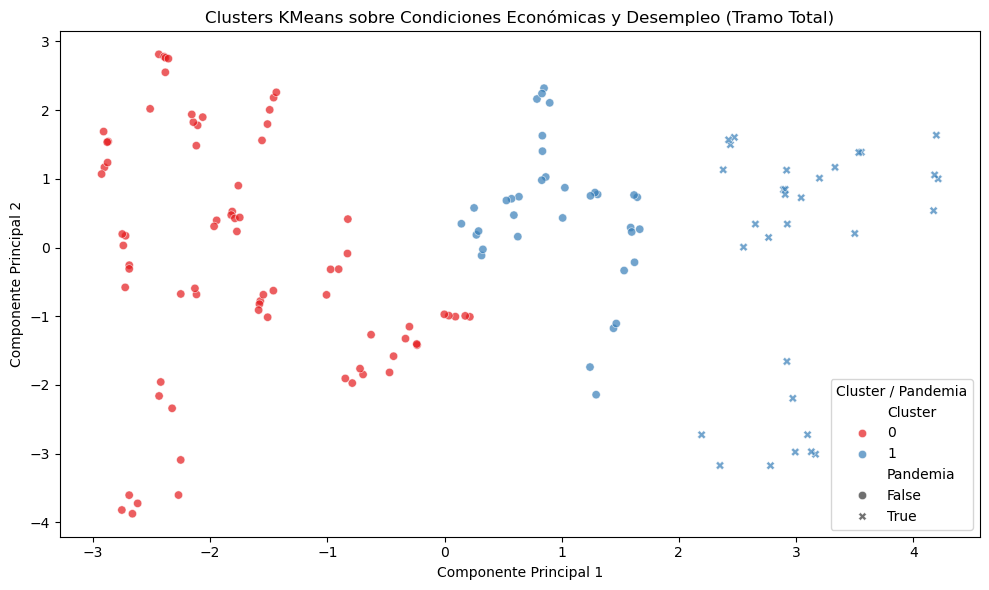

In [50]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1. Seleccionar variables relevantes para clustering
cluster_vars = [
    "Tasa de desempleo",
    "Sueldo nominal USD",
    "Sueldo mínimo USD",
    "Razón sueldo nominal/minimo",
    "Razón sueldo minimo/ipc",
    "PIB per capita",
    "Dólar observado",
    "ipc",
    "TPM"
]

df_cluster = df_encoded[df_encoded["Tramo etario_Total"] == 1].copy()
df_cluster = df_cluster.dropna(subset=cluster_vars + ["Pandemia"])  # Eliminar filas con valores nulos

# 2. Estandarizar las variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster[cluster_vars])

# 3. Aplicar KMeans (e.g., 3 clusters)
kmeans = KMeans(n_clusters=2, random_state=42)
df_cluster["Cluster"] = kmeans.fit_predict(X_scaled)

# 4. Reducir a 2 dimensiones para graficar con PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_cluster["PC1"] = X_pca[:, 0]
df_cluster["PC2"] = X_pca[:, 1]

# 5. Graficar los clusters con color y estilo según Pandemia
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_cluster,
    x="PC1",
    y="PC2",
    hue="Cluster",
    style="Pandemia",
    palette="Set1",
    alpha=0.7
)
plt.title("Clusters KMeans sobre Condiciones Económicas y Desempleo (Tramo Total)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Cluster / Pandemia")
plt.tight_layout()
plt.show()


En este código implementamos Kmeans con 2 clusters luego de utilizar PCA para reducir la dimensionalidad del conjunto de datos a dos componentes principales, facilitando la visualización. Esto lo hicimos para ver si los datos de pandemia se agrupan lejos del resto, al ver el grafico vemos que esto si ocurre y todos los datos estan agrupados a la derecha en el cluster 1, por eso, y teniendo en cuenta los graficos anteriores tomeremos el periodo de pandemia como anomalo y realizaremos el analisis de nuevo al quitar la pandemia.

## Analisis sin pandemia

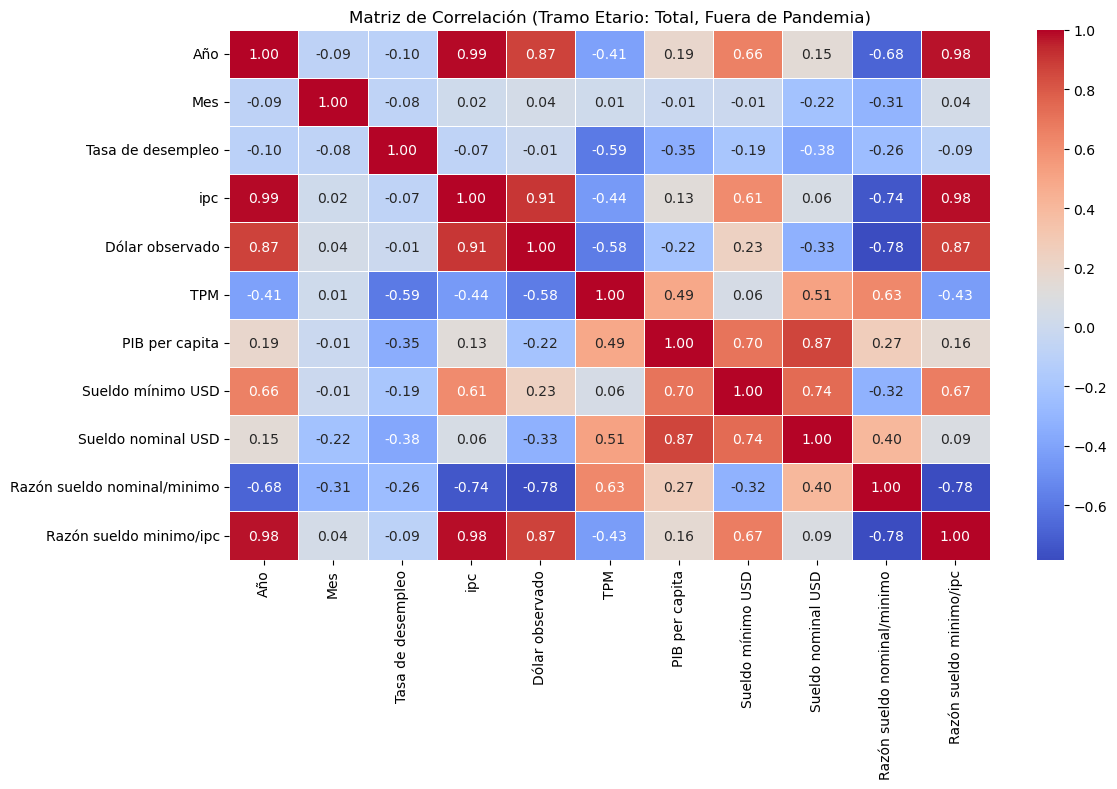


Suma de correlaciones absolutas (orden ascendente):
Mes                            1.830648
Tasa de desempleo              3.117088
PIB per capita                 4.382159
Sueldo nominal USD             4.747521
TPM                            5.162560
Sueldo mínimo USD              5.184052
Dólar observado                5.841798
ipc                            5.956399
Razón sueldo minimo/ipc        6.093376
Año                            6.107202
Razón sueldo nominal/minimo    6.165569
dtype: float64

Mayores correlaciones absolutas con la tasa de desempleo:
Tasa de desempleo              1.000000
TPM                            0.594365
Sueldo nominal USD             0.382994
PIB per capita                 0.348407
Razón sueldo nominal/minimo    0.257785
Sueldo mínimo USD              0.191135
Año                            0.096759
Razón sueldo minimo/ipc        0.087805
Mes                            0.078277
ipc                            0.073657
Dólar observado                0.

In [53]:
# Filtrar para analizar sin el momento anomalo de la pandemia
dropped=["Tasa de empleo","Fecha","Pandemia","Tramo etario_15-24 años","Tramo etario_25-34 años","Tramo etario_35-44 años","Tramo etario_45-54 años","Tramo etario_55-64 años","Tramo etario_65 años y más","Tramo etario_Total"]
df_total_s = df_total[df_total["Pandemia"] == False].drop(columns=dropped).copy()

# Visualizar con un mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(df_total_s.select_dtypes(include="number").corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Matriz de Correlación (Tramo Etario: Total, Fuera de Pandemia)")
plt.tight_layout()
plt.show()

# Calcular y mostrar suma de correlaciones absolutas (orden ascendente)
suma_corr_abs = df_total_s.select_dtypes(include="number").corr().abs().sum().sort_values()
print("\nSuma de correlaciones absolutas (orden ascendente):")
print(suma_corr_abs)
print("\nMayores correlaciones absolutas con la tasa de desempleo:")
print(df_total_s.select_dtypes(include="number").corr()["Tasa de desempleo"].abs().sort_values(ascending=False))

Vemos ahora que hubo cambios respecto a la correlación con pandemia. Ahora todas las variables se realionan inversamente con
la tasa de desempleo, siendo la que más destaca la TPM, el sueldo nominal en dolares y el PIB per capita.

## Regresion lineal para el desempleo vs las variables

La pendiente de Tasa de desempleo vs Sueldo nominal USD es:-0.0033495019674578894
El intercepto de Tasa de desempleo vs Sueldo nominal USD es:9.867264707582441


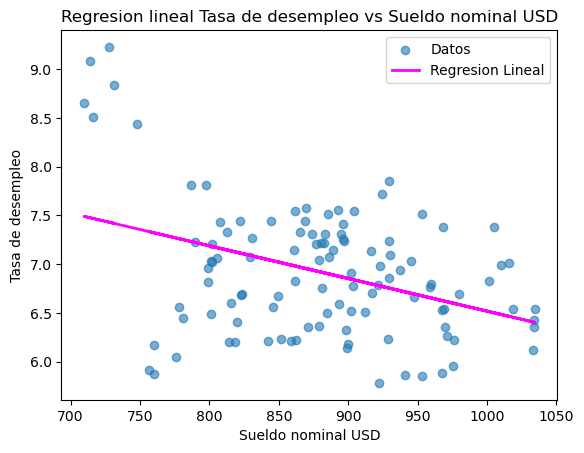

In [56]:
import numpy as np

def regressionlineal(x="Sueldo nominal USD",y="Tasa de desempleo"):
        X_f=df_total_s[[x]]
        y_f=df_total_s[[y]]
        lr = LinearRegression()
        lr.fit(X_f,y_f)
        pendiente =lr.coef_[0][0]
        intercept = lr.intercept_[0]
        y1 = pendiente*X_f + intercept
        print(f"La pendiente de {y} vs {x} es:{pendiente}")
        print(f"El intercepto de {y} vs {x} es:{intercept}")
        
        plt.scatter(X_f, y_f, alpha=0.6, label="Datos")
        plt.title(f"Regresion lineal {y} vs {x}")
        plt.xlabel(f'{x}')
        plt.ylabel(f'{y}')
        plt.plot(X_f, y1, color='magenta', lw=2, linestyle='-', label="Regresion Lineal")
        plt.legend()
regressionlineal()

La pendiente de Tasa de desempleo vs Sueldo mínimo USD es:-0.0038539730652176227
El intercepto de Tasa de desempleo vs Sueldo mínimo USD es:8.415889883631548


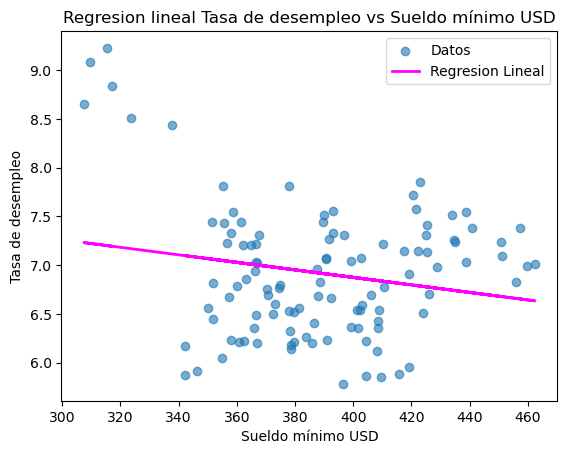

In [57]:
regressionlineal("Sueldo mínimo USD")

La pendiente de Tasa de desempleo vs Razón sueldo nominal/minimo es:-1.2401126219418357
El intercepto de Tasa de desempleo vs Razón sueldo nominal/minimo es:9.733193816328853


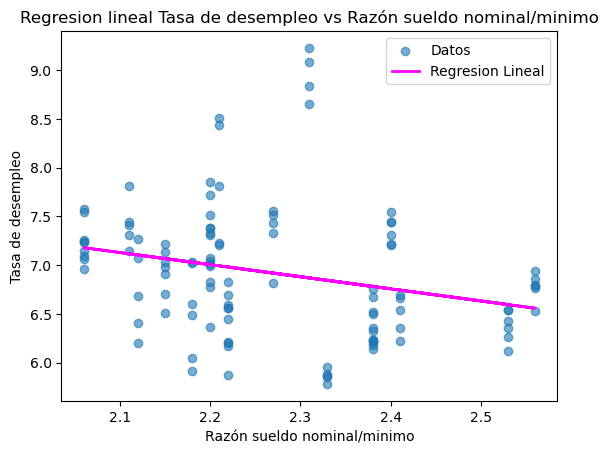

In [58]:
regressionlineal("Razón sueldo nominal/minimo")

La pendiente de Tasa de desempleo vs Razón sueldo minimo/ipc es:-0.00017746253175672131
El intercepto de Tasa de desempleo vs Razón sueldo minimo/ipc es:7.514269415503597


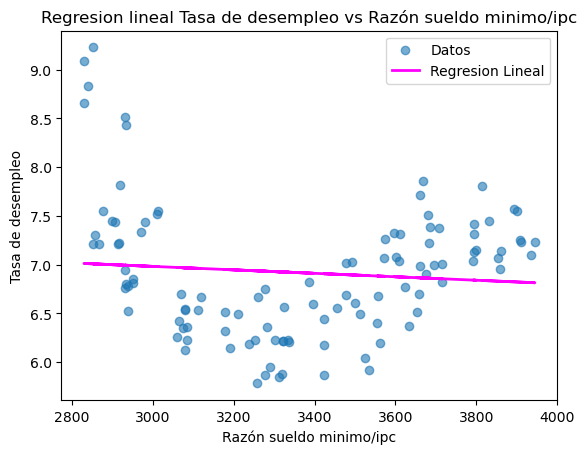

In [59]:
regressionlineal("Razón sueldo minimo/ipc")

La pendiente de Tasa de desempleo vs PIB per capita es:-0.0002558324604280585
El intercepto de Tasa de desempleo vs PIB per capita es:10.622580098377174


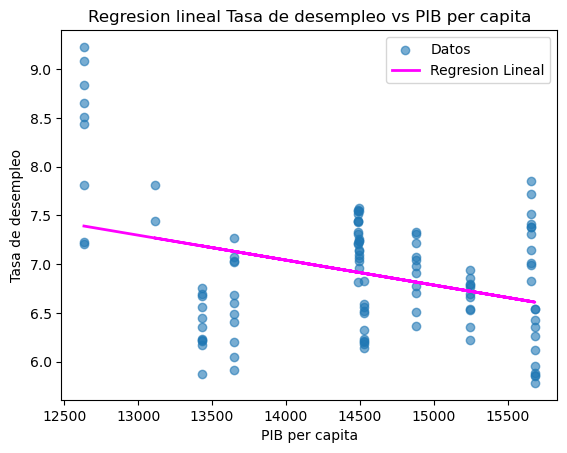

In [60]:
regressionlineal("PIB per capita")

La pendiente de Tasa de desempleo vs Dólar observado es:-4.48674226479273e-05
El intercepto de Tasa de desempleo vs Dólar observado es:6.9451200618214095


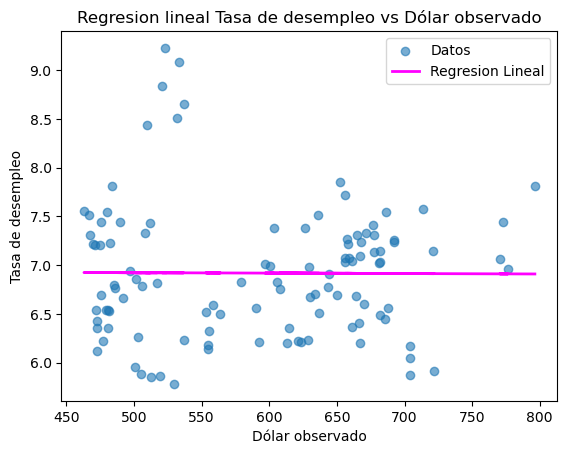

In [61]:
regressionlineal("Dólar observado")

La pendiente de Tasa de desempleo vs ipc es:-0.007950627598268709
El intercepto de Tasa de desempleo vs ipc es:7.459521627762674


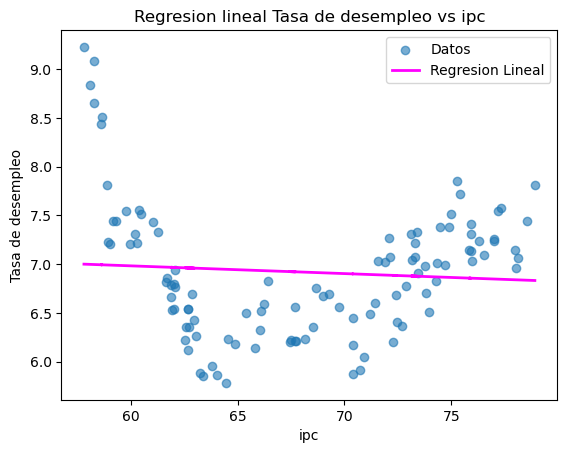

In [62]:
regressionlineal("ipc")

La pendiente de Tasa de desempleo vs TPM es:-0.34072935531909854
El intercepto de Tasa de desempleo vs TPM es:8.087848360436624


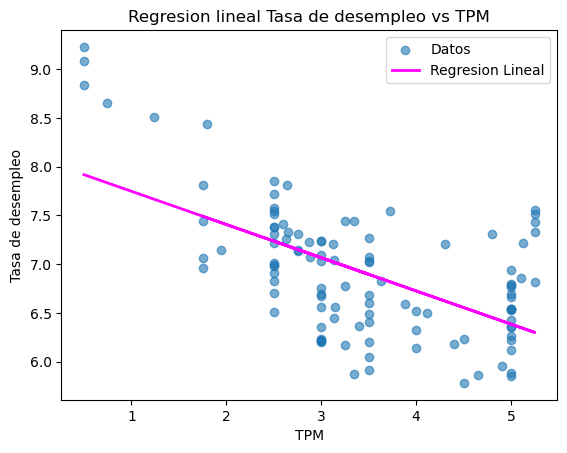

In [63]:
regressionlineal("TPM")

Los graficos confirman los datos de la matriz de correlación, mostrandonos que la variable que tiene una relacion
lineal inversa más clara es TPM seguida de el sueldo nominal en dolares, pero siendo TPM donde se nota bastante más. Tambien se puede ver que tanto que con IPC, como con la Razón del sueldo minimo con IPC se puede ver una parabola en la que los valores más bajos del desempleo son los que se encuentran en el centro.

## Análisis de Regresión Ridge y Kernel Ridge para Predecir la Tasa de Desempleo

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def analizar_feature(df, feature):
    X = df[[feature]].values
    X_scaled = StandardScaler().fit_transform(X)
    y = df['Tasa de desempleo']
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )

    ridge = Ridge()
    krr = KernelRidge(kernel='rbf')
    ridge.fit(X_train, y_train)
    krr.fit(X_train, y_train)

    X_plot = np.linspace(X_scaled.min(), X_scaled.max(), 200).reshape(-1, 1)
    ridge_pred = ridge.predict(X_plot)
    krr_pred = krr.predict(X_plot)

    print(f"[{feature}] Ridge MSE - Train: {mean_squared_error(y_train, ridge.predict(X_train)):.4f}")
    print(f"[{feature}] KRR MSE - Train: {mean_squared_error(y_train, krr.predict(X_train)):.4f}")

    plt.figure(figsize=(8, 5))
    plt.scatter(X_scaled, y, alpha=0.5, label='Datos reales')
    plt.plot(X_plot, ridge_pred, color='red', label='Ridge (Rojo)')
    plt.plot(X_plot, krr_pred, color='yellow', label='Kernel Ridge (Amarillo)')
    plt.title(f'Tasa de Desempleo vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('Tasa de Desempleo')
    plt.legend()
    plt.grid(True)
    plt.show()


[Sueldo mínimo USD] Ridge MSE - Train: 0.4175
[Sueldo mínimo USD] KRR MSE - Train: 0.4321


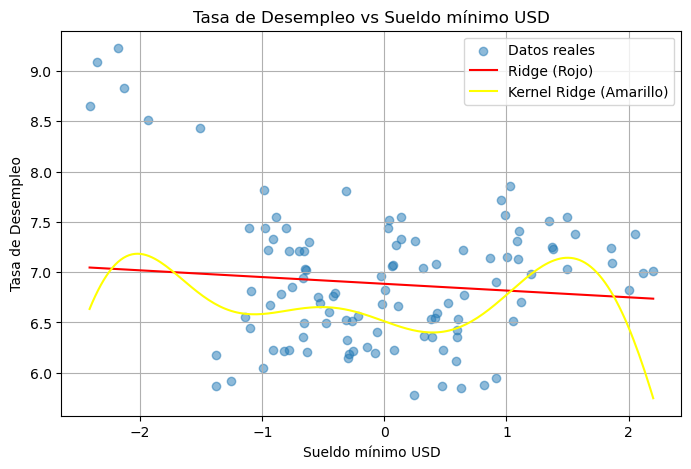

In [67]:
analizar_feature(df_total_s, 'Sueldo mínimo USD')

[Sueldo nominal USD] Ridge MSE - Train: 0.3801
[Sueldo nominal USD] KRR MSE - Train: 0.4601


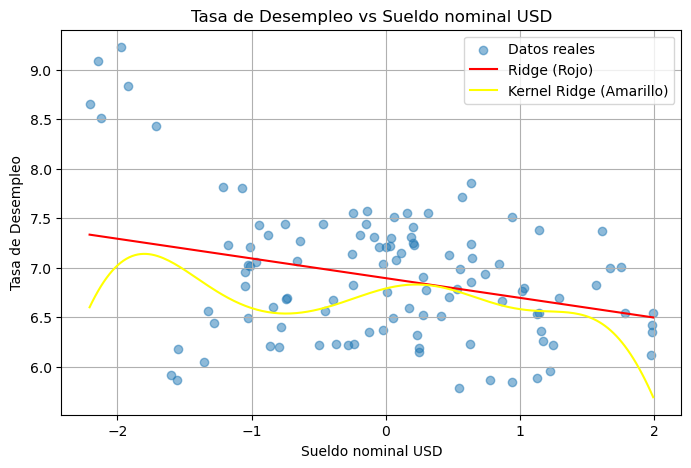

In [68]:
analizar_feature(df_total_s, 'Sueldo nominal USD')

[PIB per capita] Ridge MSE - Train: 0.3825
[PIB per capita] KRR MSE - Train: 0.3338


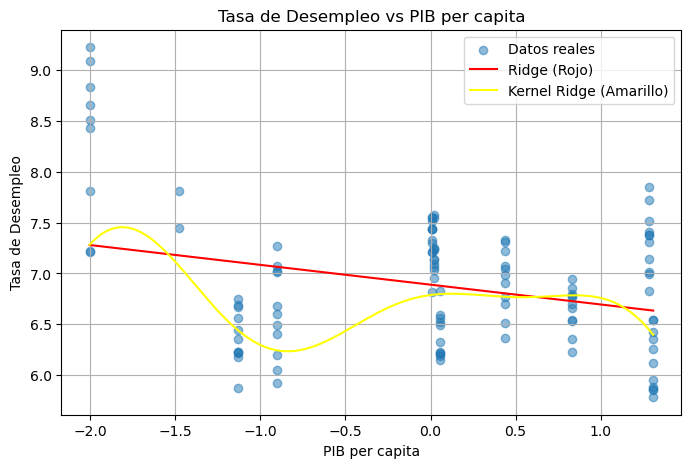

In [69]:
analizar_feature(df_total_s, 'PIB per capita')

[Dólar observado] Ridge MSE - Train: 0.4220
[Dólar observado] KRR MSE - Train: 0.5456


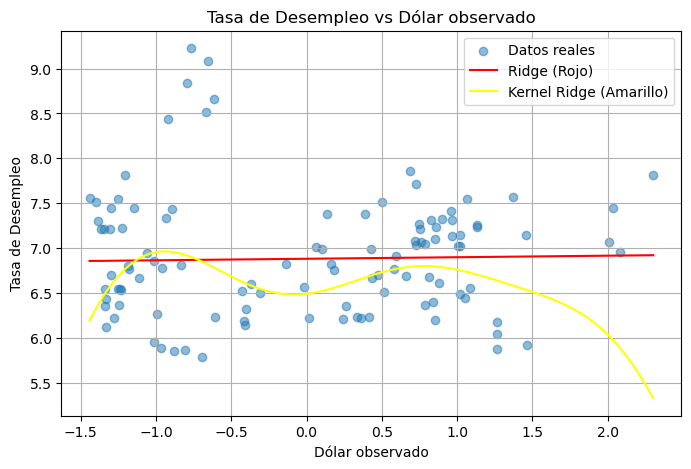

In [70]:
analizar_feature(df_total_s, 'Dólar observado')

[ipc] Ridge MSE - Train: 0.4223
[ipc] KRR MSE - Train: 0.2378


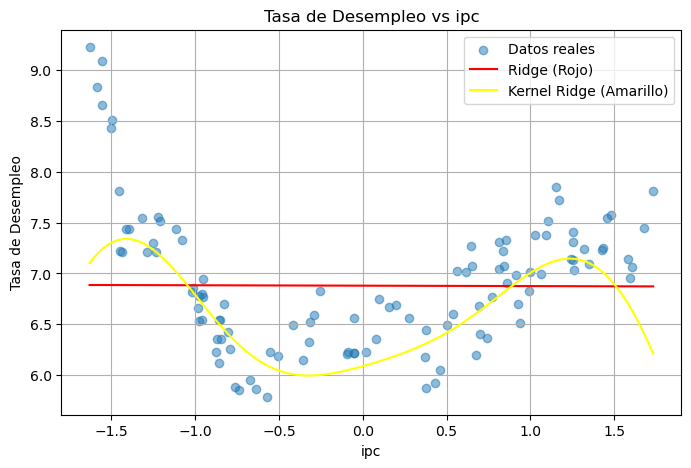

In [71]:
analizar_feature(df_total_s, 'ipc')

[Razón sueldo nominal/minimo] Ridge MSE - Train: 0.3909
[Razón sueldo nominal/minimo] KRR MSE - Train: 0.4683


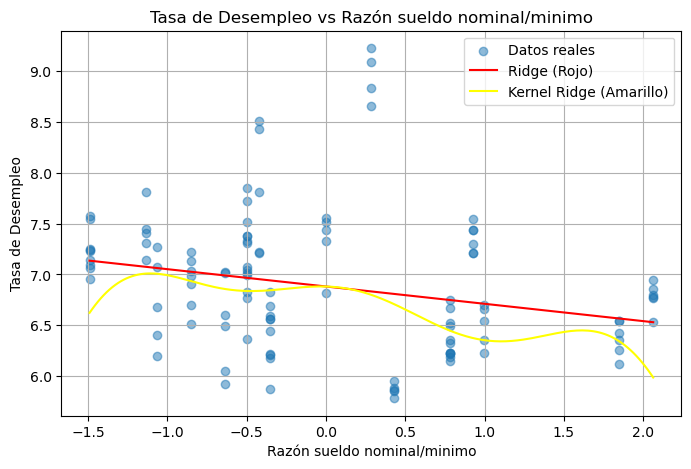

In [72]:
analizar_feature(df_total_s, 'Razón sueldo nominal/minimo')

[Razón sueldo minimo/ipc] Ridge MSE - Train: 0.4219
[Razón sueldo minimo/ipc] KRR MSE - Train: 0.2876


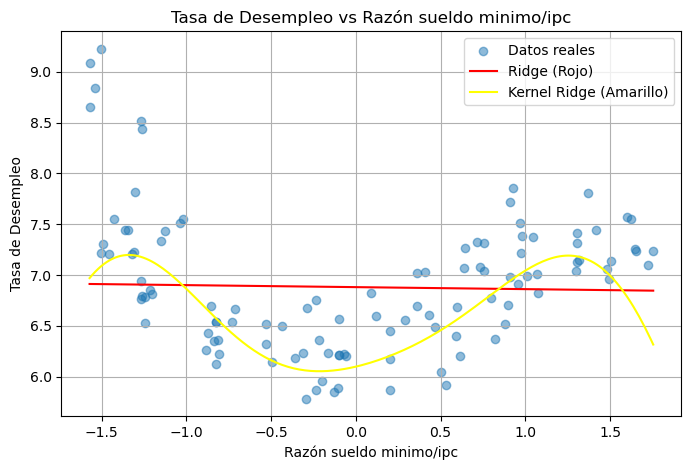

In [73]:
analizar_feature(df_total_s, 'Razón sueldo minimo/ipc')

[TPM] Ridge MSE - Train: 0.2882
[TPM] KRR MSE - Train: 0.3831


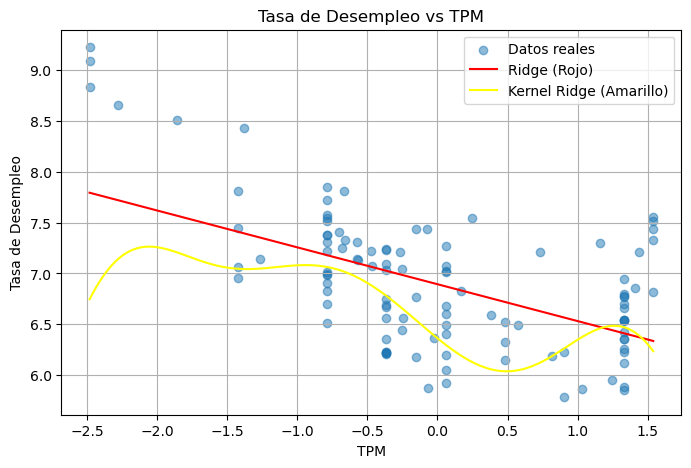

In [74]:
analizar_feature(df_total_s, 'TPM')

Se evalúa el desempeño de modelos Ridge y Kernel Ridge (con kernel RBF) utilizando las distintas variables económicas
como predictores individuales de la tasa de desempleo. Se reportan los errores cuadráticos medios (MSE) de entrenamiento y testing, junto con gráficos de dispersión y curvas de predicción.

Vemos con los resultados que las variables individuales que logran regresiones con menor mse son:
- TPM con regresión Ridge
- IPC con regresión Kernel Ridge
- Razón sueldo minimo/IPC con regresión Kernel Ridge
  
La regresión Ridge viene de la regresión lineal y debido a eso TPM es el que tiene menor MSE con esa regresión seguida de Sueldo nominal en USD, ya que como vimos en el paso anterior son las que más parecen tener una relación lineal con la variable desempleo.
La regresión Kernel Ridge hace curvas más complejas y nos sirvio para ver más claramente las relaciones no lineales de las variables IPC y Razón sueldo minimo/IPC, en las que sus valores más bajos estan por su centro. Esto nos hace tomar más en cuenta la importancia de estas variables aunque su relación lineal sea bastante baja.

## Análisis de Regresión con todas las varibles para predecir Tasa de desempleo

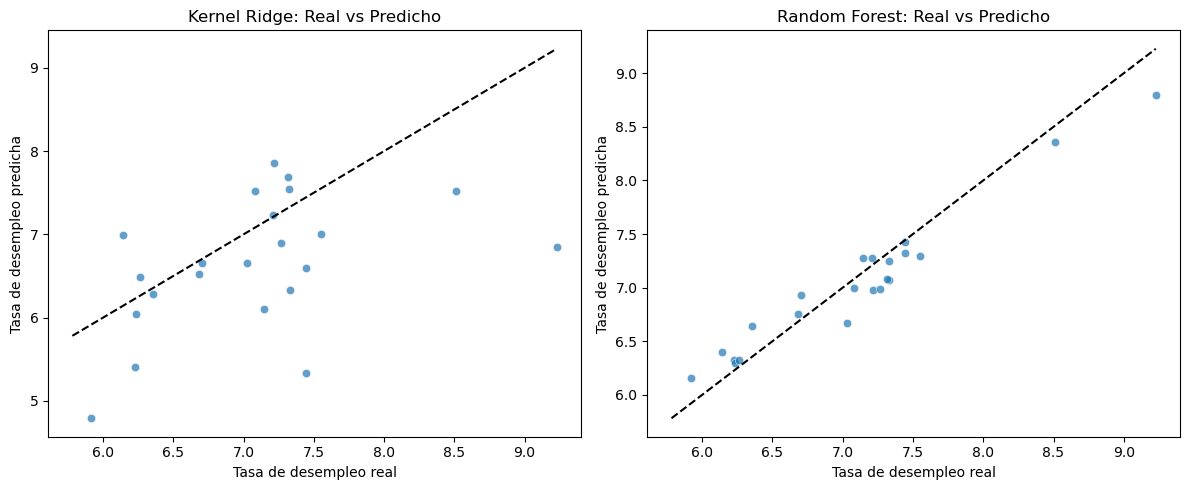

Kernel Ridge - MSE: 0.8181
Random Forest - MSE: 0.0448


In [78]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
# 1. Definir variables X e y
#df_encoded_s=df_encoded[df_encoded["Pandemia"] == False].drop(columns=["Fecha"])
df_model = df_total_s.copy()
df_model = df_model.dropna(subset=["Tasa de desempleo"])  # Eliminar nulos en y

X = df_model.drop(columns=["Tasa de desempleo"])  # Todas menos la target
y = df_model["Tasa de desempleo"]

# 2. Separar en entrenamiento y test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Estandarizar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Modelos
def train_kernel_ridge(X_train, y_train, alpha=1.0, kernel='rbf'):
    model = KernelRidge(alpha=alpha, kernel=kernel)
    model.fit(X_train, y_train)
    return model

def train_random_forest(X_train, y_train, n_estimators=100, max_depth=None):
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)
    return model

# 5. Entrenar modelos
kr_model = train_kernel_ridge(X_train_scaled, y_train)
rf_model = train_random_forest(X_train_scaled, y_train)

# 6. Predicciones
y_pred_kr = kr_model.predict(X_test_scaled)
y_pred_rf = rf_model.predict(X_test_scaled)

# 7. Gráficos de dispersión real vs predicho
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Kernel Ridge
sns.scatterplot(x=y_test, y=y_pred_kr, ax=axes[0], alpha=0.7)
axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
axes[0].set_title("Kernel Ridge: Real vs Predicho")
axes[0].set_xlabel("Tasa de desempleo real")
axes[0].set_ylabel("Tasa de desempleo predicha")

# Random Forest
sns.scatterplot(x=y_test, y=y_pred_rf, ax=axes[1], alpha=0.7)
axes[1].plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
axes[1].set_title("Random Forest: Real vs Predicho")
axes[1].set_xlabel("Tasa de desempleo real")
axes[1].set_ylabel("Tasa de desempleo predicha")

plt.tight_layout()
plt.show()
# Calcular MSE
mse_kr = mean_squared_error(y_test, y_pred_kr)
mse_rf = mean_squared_error(y_test, y_pred_rf)

# Imprimir resultados
print(f"Kernel Ridge - MSE: {mse_kr:.4f}")
print(f"Random Forest - MSE: {mse_rf:.4f}")

Este código entrena y compara dos modelos de regresión —Kernel Ridge y Random Forest— para predecir la tasa de desempleo a partir de múltiples variables económicas y categóricas previamente codificadas. Primero se separan los datos en conjuntos de entrenamiento y prueba, estandarizando las variables para mejorar el desempeño de los modelos. Luego, ambos modelos son entrenados con los datos escalados y utilizados para predecir sobre el conjunto de prueba. Los resultados se visualizan mediante gráficos de dispersión que comparan los valores reales versus los predichos, junto con la línea de referencia ideal. El rendimiento de cada modelo se evalúa usando el error cuadrático medio (MSE), proporcionando una medida cuantitativa del ajuste. Esto permite comparar qué modelo logra una mejor precisión. Finalmente, se imprime el MSE de cada modelo para una interpretación directa.

El bajo mse nos muestra que ambas regresiones predicen de muy buena manera la tasa de desempleo,
esto habiendo entrenado con las variables que más afectaban al desempleo de nuestro dataframe, lo que nos indica que las variables en conjunto realizan una buena regresión, nos quedaremos con la regresion de Random Forest porque genera mejores resultados.

Importancia de las características :
ipc                            0.338085
TPM                            0.196273
Razón sueldo minimo/ipc        0.110382
PIB per capita                 0.106473
Sueldo mínimo USD              0.068589
Mes                            0.051945
Sueldo nominal USD             0.040693
Año                            0.040387
Razón sueldo nominal/minimo    0.027858
Dólar observado                0.019315
dtype: float64


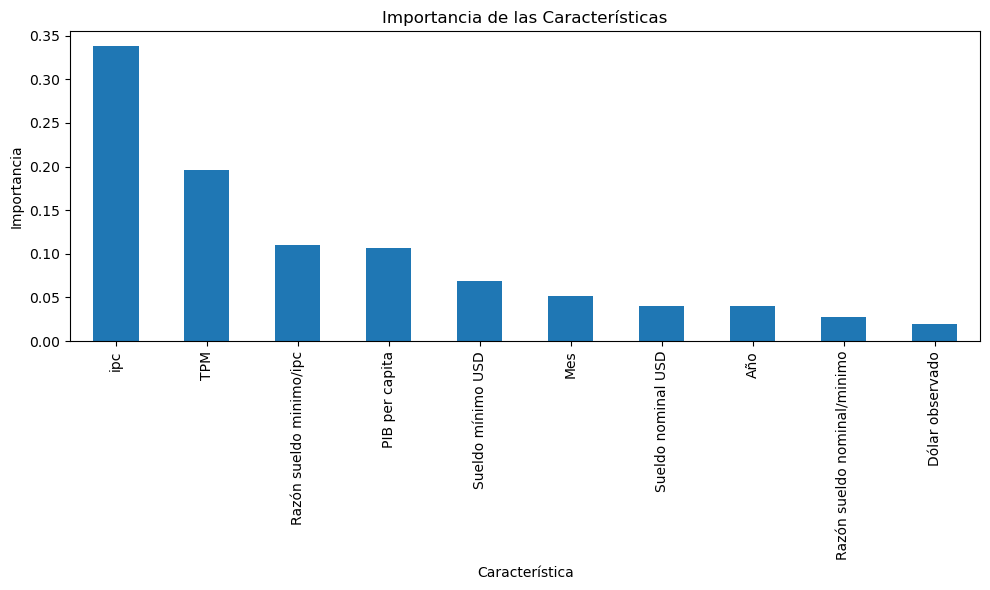

In [81]:
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print("Importancia de las características :")
print(feature_importances)

# Graficar la importancia de las características
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title('Importancia de las Características')
plt.ylabel('Importancia')
plt.xlabel('Característica')
plt.tight_layout()
plt.show()

Calculamos la importancia que le dio la regresión Random Forest a cada variable para ver cuales son las que tomo más en
cuenta para predecir el desempleo. Viendo que las 3 que tienen mayor importancia son las que tuvieron mejor mse de manera individual, TPM por su relación lineal, e ipc y Razón sueldo mínimo/IPC con sus relaciones no lineales. Con estos resultados podemos ver que esas son las variables que más afectarían a la tasa de desempleo.

## Producto Final
- Agrupamos un Dataframe limpio y consolidado.
- Creamos Gráficos comparativos, análisis de correlación y conclusiones económicas respecto a las variables.

## Conclusión
- Se confirman las relaciones economicas entre las variables.
- Se encuentra correlación de la tasa de desempleo con el sueldo mínimo, visible en la Razón sueldo mínimo/IPC.
- TPM e IPC presentan mayor importancia para la Tasa de desempleo.
- La pandemia fue un evento anómalo que fue mejor separarla para el analisis del comportamiento normal.